# 一、加载常用库

In [1]:
import numpy as np
import pandas as pd
from skimage import morphology,measure,draw

from sklearn.cluster import KMeans
from skimage.transform import resize
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline

import warnings #不显示乱七八糟的warning
warnings.filterwarnings("ignore")

# 二、设置环境

- 注意这里另外建立了一个npy_visual文件夹，只存放一组image和mask

In [2]:
luna_path = './'
luna_subset_path = luna_path + 'sample_patients/'
file_list = glob(luna_subset_path + "*.mhd")
df_node = pd.read_csv(luna_path + 'csv_files/' + 'annotations.csv')
npy_list=glob(luna_path + 'npy_visual/' + "images_*.npy")


output_path = luna_path + 'npy/'
working_path = luna_path + 'output/'

# 三、处理数据

## 3.1 像素归一化

In [3]:
for img_file in npy_list:
    # 只能用float64，用float16归一化后都是0
    imgs_to_process = np.load(img_file).astype(np.float64) 


img_ = imgs_to_process[1]
img2 = imgs_to_process[1]


#像素归一化
mean = np.mean(img_)
std = np.std(img_)
img = img_-mean
img = img/std

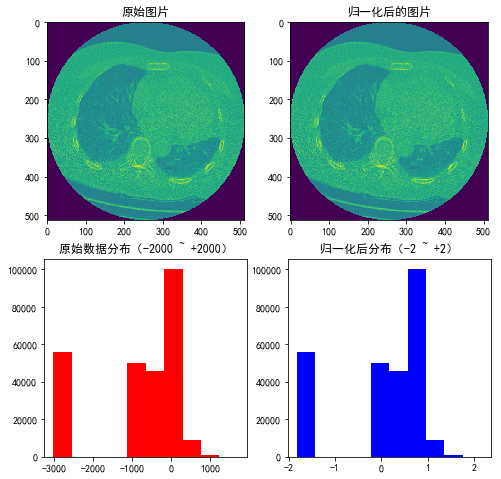

In [4]:
fig,ax = plt.subplots(2,2,figsize=[8,8])
        
ax[0,0].imshow(img_ )
ax[0,0].set_title(u'原始图片')
ax[0,1].imshow(img)
ax[0,1].set_title(u'归一化后的图片')
ax[1,0].hist(img_.reshape(img_.shape[0]*img_.shape[1]),10,facecolor='r')
ax[1,0].set_title(u'原始数据分布（-2000 ~ +2000）')
ax[1,1].hist(img.reshape(img_.shape[0]*img_.shape[1]),10,facecolor='blue')
ax[1,1].set_title(u'归一化后分布（-2 ~ +2）')

## 3.2 使用图片中心区域的均值，处理最小最大值

In [5]:
# 在512像素的图像中，切掉边缘部分，取中间（100~400）部分的均值替代最大最小像素值
img1 = np.zeros_like(img_)
img1 = img_


# To improve threshold finding, I'm moving the 
# underflow and overflow on the pixel spectrum
#为增强阈值的寻找，把最大最小像素值替换为均值
        

middle = img[100:400,100:400] 
mean = np.mean(middle)  
max = np.max(img)
min = np.min(img)
img[img==max]=mean
img[img==min]=mean




Y1=np.array([90,90,410,410])
X1=np.array([90,100,100,90])
Y2=np.array([90,410,410,90])
X2=np.array([410,410,400,400])
Y3=np.array([410,410,400,400])
X3=np.array([90,410,410,90])
Y4=np.array([90,100,100,90])
X4=np.array([90,90,410,410])
rr1, cc1=draw.polygon(Y1,X1)
draw.set_color(img1,[rr1,cc1],255)
rr2, cc2=draw.polygon(Y2,X2)
draw.set_color(img1,[rr2,cc2],255)
rr3, cc3=draw.polygon(Y3,X3)
draw.set_color(img1,[rr3,cc3],255)
rr4, cc4=draw.polygon(Y4,X4)
draw.set_color(img1,[rr4,cc4],255)

Y=np.array([400,400,100,100])
X=np.array([100,400,400,100])
rr, cc=draw.polygon(Y,X)
draw.set_color(img1,[rr,cc],100,alpha=0.6)




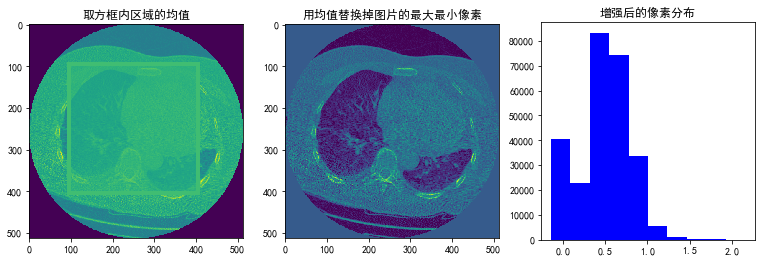

In [6]:
fig,ax = plt.subplots(1,3,figsize=[13,4])
        
ax[0].imshow(img1)
ax[0].set_title(u'取方框内区域的均值')
ax[1].imshow(img)
ax[1].set_title(u'用均值替换掉图片的最大最小像素')
ax[2].hist(img.reshape(img.shape[0]*img.shape[1]),10,facecolor='blue')
ax[2].set_title(u'增强后的像素分布')

## 3.3 使用kmeans分割前景和背景

In [7]:
#使用Kmeans分离前景（不透明的组织）和背景（透明组织，即肺），仅在图像的中心进行学习fit，以尽可能避免图像的非组织部分
        
kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
centers = sorted(kmeans.cluster_centers_.flatten())
threshold = np.mean(centers)
thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

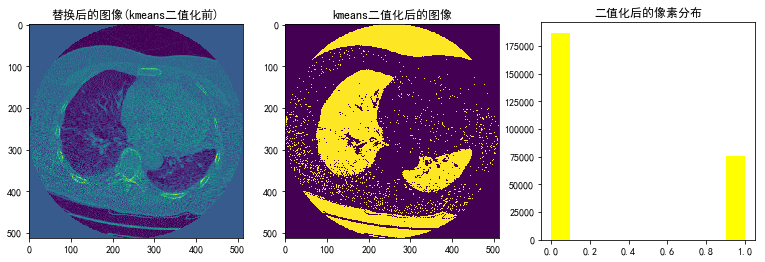

In [8]:
fig,ax = plt.subplots(1,3,figsize=[13,4])
        
ax[0].imshow(img)
ax[0].set_title(u'替换后的图像(kmeans二值化前)')
ax[1].imshow(thresh_img)
ax[1].set_title(u'kmeans二值化后的图像')
ax[2].hist(thresh_img.reshape(thresh_img.shape[0]*thresh_img.shape[1]),10,facecolor='yellow')
ax[2].set_title(u'二值化后的像素分布')

## 3.4 开运算（opening)，先腐蚀再膨胀，消除小物体或小斑块

- 注意：由于前面已经做过二值化，这里使用binary_erosion函数加快速度，如果没做二值化，则要改回erosion，dilation同此

In [9]:
#用腐蚀的办法可以清除小于n毫米的一些区域的小颗粒，然后使用更大的膨胀的方法使肺区域吞没血管
        
eroded = morphology.binary_erosion(thresh_img,np.ones([4,4]))
dilation = morphology.binary_dilation(eroded,np.ones([10,10]))

#标记每个区域并获取区域属性背景区域通过移除具有大范围的bbox的区域而被去除。另外，肺通常远离图像的顶部和底部，
#因此任何太靠近的区域 到顶部和底部被去除这不会影响肺的分割，效果较好

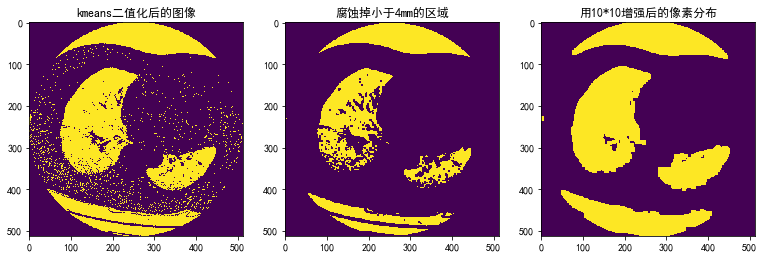

In [10]:
fig,ax = plt.subplots(1,3,figsize=[13,4])
        
ax[0].imshow(thresh_img)
ax[0].set_title(u'kmeans二值化后的图像')
ax[1].imshow(eroded)
ax[1].set_title(u'腐蚀掉小于4mm的区域')
ax[2].imshow(dilation)
ax[2].set_title(u'用10*10增强后的像素分布')

## 3.5 用label标注连通区域

- 图片的label可以记录帮助区分肺部和结节

In [11]:
labels = measure.label(dilation)
label_vals = np.unique(labels)

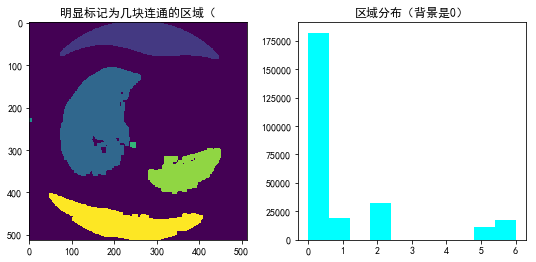

In [12]:
fig,ax = plt.subplots(1,2,figsize=[9,4])

ax[0].imshow(labels)
ax[0].set_title(u'明显标记为几块连通的区域（')
ax[1].hist(labels.reshape(labels.shape[0]*labels.shape[1]),10,facecolor='aqua')
ax[1].set_title(u'区域分布（背景是0）')

## 3.6 标记图像区域的测量特性，定义一个保留肺部的mask

- bbox是确定连通区域的边框

In [13]:
for i in range(len(imgs_to_process)):
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<475 and B[3]-B[1]<475 and B[0]>40 and B[2]<472:
            good_labels.append(prop.label)
    mask = np.ndarray([512,512],dtype=np.int8)
    mask[:] = 0
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation
    imgs_to_process[i] = mask
np.save(img_file.replace("images","lungmask"),imgs_to_process)

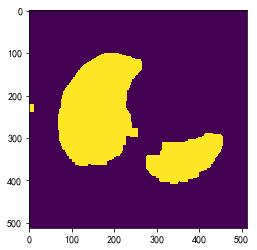

In [14]:
plt.imshow(mask)

## 3.7 将肺部的mask还原到原始大小

In [15]:
out_images = []      
out_nodemasks = []   

npy_image=glob(luna_path + 'npy_visual/' + "images_*.npy")
npy_lungmask=glob(luna_path + 'npy_visual/' + "lungmask_*.npy")
npy_masks=glob(luna_path + 'npy_visual/' + "masks_*.npy")

imgs_to_process = np.load(npy_image[0])
masks = np.load(npy_lungmask[0])
node_masks = np.load(npy_masks[0])
#    for i in range(len(imgs_to_process)):
mask = masks[0]
node_mask = node_masks[0]
img = imgs_to_process[0]
img_node = imgs_to_process[0]
new_size = [512,512]   # we're scaling back up to the original size of the image
img= mask*img          # apply lung mask
img_node =  node_mask * img_node      
        
        
        

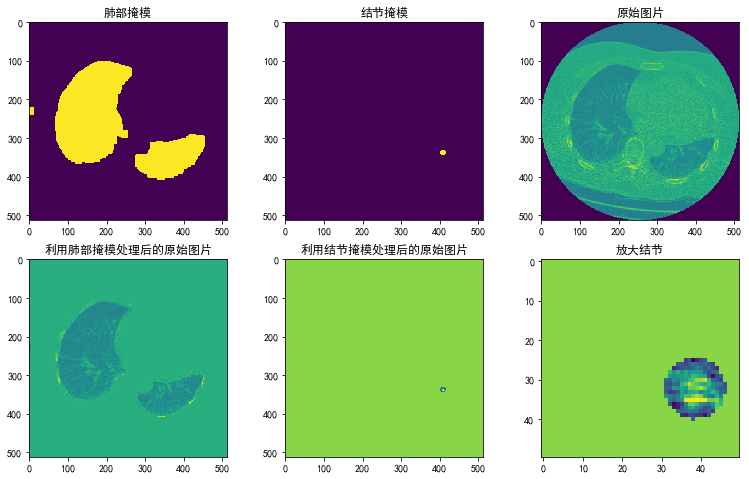

In [16]:
fig,ax = plt.subplots(2,3,figsize=[13,8])
        

ax[0,0].imshow(mask)
ax[0,0].set_title(u'肺部掩模')
ax[0,1].imshow(node_mask)
ax[0,1].set_title(u'结节掩模')
ax[0,2].imshow(imgs_to_process[0])
ax[0,2].set_title(u'原始图片')

ax[1,0].imshow(img)
ax[1,0].set_title(u'利用肺部掩模处理后的原始图片')
ax[1,1].imshow(img_node)
ax[1,1].set_title(u'利用结节掩模处理后的原始图片')
ax[1,2].imshow(img_node[305:355,370:420])
ax[1,2].set_title(u'放大结节')

## 3.8 对已还原的肺部mask再次做归一化、圈出连通区域

In [17]:
#
# renormalizing the masked image (in the mask region)
#
new_mean = np.mean(img[mask>0])  
new_std = np.std(img[mask>0])
#
#  Pulling the background color up to the lower end
#  of the pixel range for the lungs
#
old_min = np.min(img)       # background color
img[img==old_min] = new_mean-1.2*new_std   # resetting backgound color
img = img-new_mean
img = img/new_std
#make image bounding box  (min row, min col, max row, max col)

labels = measure.label(mask)
regions = measure.regionprops(labels)

labels2 = labels

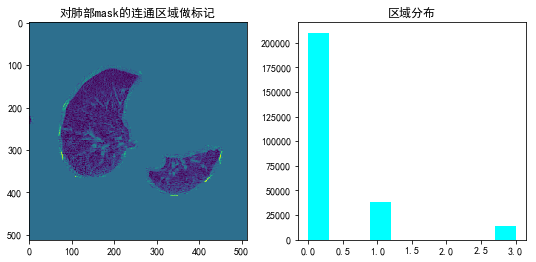

In [18]:
fig,ax = plt.subplots(1,2,figsize=[9,4])

ax[0].imshow(img)
ax[0].set_title(u'对肺部mask的连通区域做标记')
ax[1].hist(labels.reshape(labels.shape[0]*labels.shape[1]),10,facecolor='aqua')
ax[1].set_title(u'区域分布')

In [19]:
#
# Finding the global min and max row over all regions
#
min_row = 512
max_row = 0
min_col = 512
max_col = 0
for prop in regions:
    B = prop.bbox
    if min_row > B[0]:
        min_row = B[0]
    if min_col > B[1]:
        min_col = B[1]
    if max_row < B[2]:
        max_row = B[2]
    if max_col < B[3]:
        max_col = B[3]
width = max_col-min_col
height = max_row - min_row
if width > height:
    max_row=min_row+width
else:
    max_col = min_col+height

img = img[min_row:max_row,min_col:max_col]
mask =  mask[min_row:max_row,min_col:max_col]

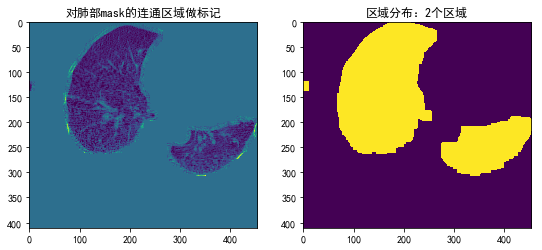

In [20]:
fig,ax = plt.subplots(1,2,figsize=[9,4])

ax[0].imshow(img)
ax[0].set_title(u'对肺部mask的连通区域做标记')
ax[1].imshow(mask)
ax[1].set_title(u'区域分布：2个区域')

## 3.9 获得最终的数据及mask

In [21]:
if max_row-min_row <5 or max_col-min_col<5:  # skipping all images with no god regions
    pass
else:
            # moving range to -1 to 1 to accomodate the resize function
    mean = np.mean(img)
    img = img - mean
    min = np.min(img)
    max = np.max(img)
    img = img/(max-min)
    new_img = resize(img,[512,512])
    new_node_mask = resize(node_mask[min_row:max_row,min_col:max_col],[512,512])
    out_images.append(new_img)
    out_nodemasks.append(new_node_mask)

num_images = len(out_images)
#
#  Writing out images and masks as 1 channel arrays for input into network
#
final_images = np.ndarray([num_images,1,512,512],dtype=np.float32)
final_masks = np.ndarray([num_images,1,512,512],dtype=np.float32)
for i in range(num_images):
    final_images[i,0] = out_images[i]
    final_masks[i,0] = out_nodemasks[i]

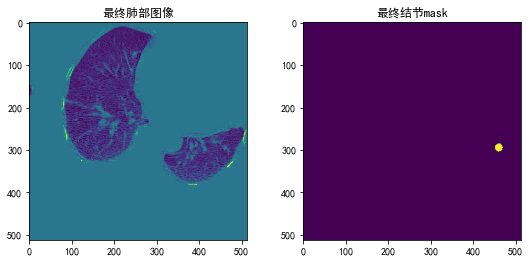

In [22]:
fig,ax = plt.subplots(1,2,figsize=[9,4])

ax[0].imshow(new_img)
ax[0].set_title(u'最终肺部图像')
ax[1].imshow(new_node_mask)
ax[1].set_title(u'最终结节mask')
